# Looking for the Optimum Model Size

In [1]:
#import
import numpy as np
import pandas as pd
import os, sys, time
import re
import progressbar
import datetime
from scipy.stats import chi2 #for chi2inv() function
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import geopandas as gpd
import matplotlib.pyplot as plt
from scipy import spatial
from tqdm import tqdm

In [2]:
#loading the data
folder = ''
filename1 = 'Implemented_linear_Franciscanerstraat_sinkhole_final.csv'
location_file = 'sinkhole_kerkrade.csv'

#load the data
data = pd.read_csv(os.path.join(folder,filename1))
location = pd.read_csv(os.path.join(folder,location_file))

#get information from pandas df
headers = list(data)
data_gdf = gpd.GeoDataFrame(data, geometry=gpd.points_from_xy(data.pnt_lon, data.pnt_lat))
data_gdf.crs = 'epsg:4326' #wgs84
data_gdf = data_gdf.to_crs('epsg:28992') #to Amersfoort Rijksdriehoekenstelsel
location_gdf = gpd.GeoDataFrame(location, geometry=gpd.points_from_xy(location.longitude, location.latitude))
location_gdf.crs = 'epsg:4326' #wgs84
location_gdf = location_gdf.to_crs('epsg:28992') # to Amersfoort Rijksdriehoekenstelsel

#make the kdtree for quick subset creation
rdx = data['pnt_rdx'].values
rdy = data['pnt_rdy'].values
rd_data = np.concatenate((rdx.reshape(len(rdx),1),rdy.reshape(len(rdy),1)),axis=1)
tree = spatial.cKDTree(rd_data)

x0 = location_gdf.geometry.x.values[0]
y0 = location_gdf.geometry.y.values[0]

#cropping the dataset
subset = tree.query_ball_point(([x0,y0]),r=80)
data = data.iloc[subset]

#make the kdtree for quick subset creation
rdx = data['pnt_rdx'].values
rdy = data['pnt_rdy'].values
rd_data = np.concatenate((rdx.reshape(len(rdx),1),rdy.reshape(len(rdy),1)),axis=1)
tree = spatial.cKDTree(rd_data)

START_EPOCH = 68
MAX_EPOCHS = START_EPOCH
# MODEL_EPOCH = 70

In [6]:
#code to filter the epoch headers out of the dataset
filter_string = re.compile(r'd_\d{8}')
epochs = list(filter(lambda x: filter_string.match(x) != None, list(data)))

# data_processed['geometry (rd)']
from sinkhole_functions import process_arc_connections as pac
processed_data_object = pac.process_arc_connections(data)
processed_data_object.process_arc_connections();
df_rd = processed_data_object.processed_data[['rdx','rdy']]

data_processed = process_arc_connections(data,epochs)

Processing Arc Connections...:   0%|          | 0/148 [00:00<?, ?it/s]

Creating tuple list.


Processing Arc Connections...: 100%|██████████| 148/148 [00:09<00:00, 16.01it/s]
N/A% (0 of 148) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished processing arc connections.
Creating tuple list.


100% (148 of 148) |######################| Elapsed Time: 0:00:07 Time:  0:00:07


Finished processing arc connections.


In [7]:
model_size_list = np.arange(30,68,1)
assert MAX_EPOCHS >= np.max(model_size_list), 'Number of epochs for the model is too large.'
#Create the delta days vector
delta_days, start_day = get_delta_day(epochs)

In [13]:
#pre allocate space
sum_flag_list = []
res_list_list = []

#loop
for i in tqdm(model_size_list,'model size'):
    MODEL_EPOCH = i
    start_epoch = START_EPOCH
    obs_epoch = len(epochs) - START_EPOCH
    model_epoch = MODEL_EPOCH
    epoch_list_new = epochs[start_epoch-model_epoch:]
    epochs_model_list = np.arange(start_epoch-model_epoch,start_epoch,1)

    data_flagged, epochs_list = arc_flagging2(data_processed,epochs,epochs_model_list,START_EPOCH)

    data_in = data_processed[epochs]
    data_in = data_in.join(data_processed['Arc'])
    n = len(data_processed)

    a, b, sigma_ehat = linear_model2(epochs,data_in,epochs_model_list)
    #recalculate the residuals
    res_list = []
    for row in range(len(data_processed)):
        y_under = data_processed[epochs].iloc[row].values
        y_under = 1000*y_under
        #predicted deformation
        delta_d = 1000*(a[row] * delta_days + b[row])
        residual = delta_d - y_under
        res_std = np.std(residual)
        res_list.append(res_std)
    
    sum_flag = data_flagged['SUMMED']
    sum_flag_list.append(np.median(sum_flag))
    res_list_list.append(np.mean(res_list))

model size:   0%|          | 0/38 [00:00<?, ?it/s]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   3%|▎         | 1/38 [00:11<07:05, 11.50s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   5%|▌         | 2/38 [00:23<06:54, 11.51s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   8%|▊         | 3/38 [00:33<06:27, 11.07s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  11%|█         | 4/38 [00:44<06:15, 11.03s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  13%|█▎        | 5/38 [00:54<05:53, 10.72s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  16%|█▌        | 6/38 [01:04<05:39, 10.62s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  18%|█▊        | 7/38 [01:14<05:25, 10.51s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  21%|██        | 8/38 [01:24<05:08, 10.28s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  24%|██▎       | 9/38 [01:34<04:54, 10.15s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:  26%|██▋       | 10/38 [01:46<04:59, 10.69s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  29%|██▉       | 11/38 [01:55<04:41, 10.42s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  32%|███▏      | 12/38 [02:05<04:26, 10.25s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  34%|███▍      | 13/38 [02:16<04:21, 10.47s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  37%|███▋      | 14/38 [02:28<04:21, 10.88s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  39%|███▉      | 15/38 [02:41<04:22, 11.43s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:  42%|████▏     | 16/38 [02:55<04:30, 12.29s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:  45%|████▍     | 17/38 [03:10<04:34, 13.06s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  47%|████▋     | 18/38 [03:22<04:11, 12.59s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  50%|█████     | 19/38 [03:33<03:52, 12.22s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  53%|█████▎    | 20/38 [03:45<03:38, 12.13s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  55%|█████▌    | 21/38 [03:56<03:22, 11.92s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  58%|█████▊    | 22/38 [04:08<03:07, 11.74s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  61%|██████    | 23/38 [04:19<02:55, 11.68s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  63%|██████▎   | 24/38 [04:31<02:42, 11.62s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  66%|██████▌   | 25/38 [04:42<02:31, 11.67s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  68%|██████▊   | 26/38 [04:54<02:18, 11.56s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  71%|███████   | 27/38 [05:05<02:06, 11.46s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  74%|███████▎  | 28/38 [05:16<01:55, 11.50s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  76%|███████▋  | 29/38 [05:28<01:43, 11.49s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  79%|███████▉  | 30/38 [05:40<01:32, 11.52s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  82%|████████▏ | 31/38 [05:51<01:20, 11.52s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  84%|████████▍ | 32/38 [06:04<01:12, 12.06s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  87%|████████▋ | 33/38 [06:18<01:02, 12.59s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  89%|████████▉ | 34/38 [06:37<00:57, 14.46s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  92%|█████████▏| 35/38 [06:51<00:43, 14.39s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:05 Time:  0:00:05


Finished checking arc for potential flag.


model size:  95%|█████████▍| 36/38 [07:09<00:30, 15.28s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  97%|█████████▋| 37/38 [07:23<00:14, 14.92s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size: 100%|██████████| 38/38 [07:40<00:00, 12.11s/it]


In [14]:
import beepy

beepy.beep('coin')

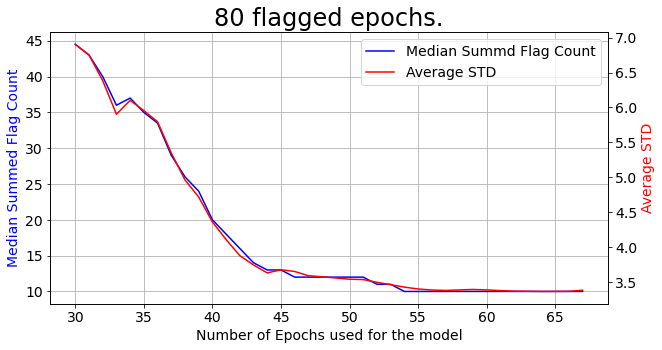

In [15]:
plt.rcParams.update({'font.size': 14})

fig, ax = plt.subplots(figsize=(10,5))
ax.set_title(f'{obs_epoch} flagged epochs.',fontsize=24)
# fig.subplots_adjust(top=0.7)

h1 = ax.plot(model_size_list,sum_flag_list,c='b',label='Median Summd Flag Count')
ax.set_ylabel('Median Summed Flag Count',c='b')

ax2 = ax.twinx()
h2 = ax2.plot(model_size_list,res_list_list,c='r',label='Average STD')
ax2.set_ylabel('Average STD',c='r')

ax.set_xlabel('Number of Epochs used for the model')

ax.grid(True)
lns = h1+h2
labs = [l.get_label() for l in lns]
ax.legend(lns, labs, loc=0);

In [ ]:
fig.savefig(os.path.join('new_folder',f'new_ModelSize_Epochs_obs{obs_epoch}.png'))

In [20]:
i

68

In [ ]:
save_folder = 'ModelSize_new2'
obs_epoch_range = np.arange(68,108,10)

if not os.path.exists(save_folder):
    os.mkdir(save_folder)

for i in obs_epoch_range:
    start_time = time.time()
    model_size_figure(i) 
    print(f'Elapsed time {(time.time()-start_time)/60} Minutes.')
#     break
beepy.beep('coin')

Processing Arc Connections...:   0%|          | 0/148 [00:00<?, ?it/s]

Creating tuple list.


Processing Arc Connections...: 100%|██████████| 148/148 [00:07<00:00, 19.09it/s]
N/A% (0 of 148) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished processing arc connections.
Creating tuple list.


100% (148 of 148) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
model size:   0%|          | 0/43 [00:00<?, ?it/s]

Finished processing arc connections.
Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:   2%|▏         | 1/43 [00:15<10:57, 15.65s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   5%|▍         | 2/43 [00:26<09:48, 14.35s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   7%|▋         | 3/43 [00:37<08:49, 13.24s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   9%|▉         | 4/43 [00:48<08:13, 12.66s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  12%|█▏        | 5/43 [01:00<07:43, 12.20s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  14%|█▍        | 6/43 [01:11<07:19, 11.89s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  16%|█▋        | 7/43 [01:26<07:41, 12.82s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:  19%|█▊        | 8/43 [01:38<07:24, 12.71s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  21%|██        | 9/43 [01:49<06:57, 12.29s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  23%|██▎       | 10/43 [02:01<06:40, 12.14s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  26%|██▌       | 11/43 [02:13<06:23, 11.98s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  28%|██▊       | 12/43 [02:25<06:10, 11.96s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  30%|███       | 13/43 [02:36<05:54, 11.82s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  33%|███▎      | 14/43 [02:48<05:44, 11.86s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  35%|███▍      | 15/43 [03:00<05:33, 11.91s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  37%|███▋      | 16/43 [03:12<05:19, 11.84s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  40%|███▉      | 17/43 [03:23<05:04, 11.73s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:  42%|████▏     | 18/43 [03:36<05:02, 12.09s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  44%|████▍     | 19/43 [03:48<04:48, 12.03s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  47%|████▋     | 20/43 [04:01<04:40, 12.18s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  49%|████▉     | 21/43 [04:13<04:25, 12.06s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  51%|█████     | 22/43 [04:25<04:19, 12.33s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  53%|█████▎    | 23/43 [04:38<04:05, 12.25s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  56%|█████▌    | 24/43 [04:50<03:55, 12.39s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  58%|█████▊    | 25/43 [05:03<03:42, 12.37s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  60%|██████    | 26/43 [05:15<03:31, 12.43s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  63%|██████▎   | 27/43 [05:27<03:17, 12.35s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  65%|██████▌   | 28/43 [05:40<03:07, 12.48s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  67%|██████▋   | 29/43 [05:53<02:54, 12.50s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  70%|██████▉   | 30/43 [06:05<02:42, 12.52s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  72%|███████▏  | 31/43 [06:18<02:30, 12.51s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  74%|███████▍  | 32/43 [06:30<02:17, 12.53s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  77%|███████▋  | 33/43 [06:43<02:05, 12.53s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  79%|███████▉  | 34/43 [06:56<01:53, 12.62s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  81%|████████▏ | 35/43 [07:08<01:40, 12.62s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  84%|████████▎ | 36/43 [07:21<01:29, 12.77s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  86%|████████▌ | 37/43 [07:34<01:16, 12.77s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  88%|████████▊ | 38/43 [07:47<01:04, 12.82s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  91%|█████████ | 39/43 [08:00<00:51, 12.83s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  93%|█████████▎| 40/43 [08:16<00:40, 13.67s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  95%|█████████▌| 41/43 [08:30<00:27, 13.76s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  98%|█████████▊| 42/43 [08:42<00:13, 13.46s/it]

Starting with arc flagging


100% (79 of 79) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


Processing Arc Connections...:   0%|          | 0/148 [00:00<?, ?it/s]

Elapsed time 9.183474063873291 Minutes.
Creating tuple list.


Processing Arc Connections...: 100%|██████████| 148/148 [00:07<00:00, 19.41it/s]
N/A% (0 of 148) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished processing arc connections.
Creating tuple list.


100% (148 of 148) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
model size:   0%|          | 0/43 [00:00<?, ?it/s]

Finished processing arc connections.
Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   2%|▏         | 1/43 [00:11<07:43, 11.04s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   5%|▍         | 2/43 [00:22<07:31, 11.02s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:   7%|▋         | 3/43 [00:35<07:45, 11.65s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:   9%|▉         | 4/43 [00:46<07:28, 11.49s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  12%|█▏        | 5/43 [00:57<07:15, 11.46s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  14%|█▍        | 6/43 [01:08<06:58, 11.32s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  16%|█▋        | 7/43 [01:19<06:46, 11.29s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  19%|█▊        | 8/43 [01:31<06:37, 11.35s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  21%|██        | 9/43 [01:42<06:25, 11.33s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  23%|██▎       | 10/43 [01:54<06:16, 11.40s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  26%|██▌       | 11/43 [02:05<06:06, 11.46s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  28%|██▊       | 12/43 [02:17<05:56, 11.50s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  30%|███       | 13/43 [02:29<05:52, 11.75s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  33%|███▎      | 14/43 [02:41<05:44, 11.86s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  35%|███▍      | 15/43 [02:53<05:31, 11.83s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  37%|███▋      | 16/43 [03:06<05:29, 12.21s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  40%|███▉      | 17/43 [03:21<05:40, 13.11s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  42%|████▏     | 18/43 [03:33<05:16, 12.68s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  44%|████▍     | 19/43 [03:45<04:59, 12.49s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  47%|████▋     | 20/43 [03:57<04:43, 12.31s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  49%|████▉     | 21/43 [04:09<04:30, 12.30s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  51%|█████     | 22/43 [04:21<04:16, 12.19s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  53%|█████▎    | 23/43 [04:33<04:03, 12.19s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  56%|█████▌    | 24/43 [04:46<03:51, 12.18s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  58%|█████▊    | 25/43 [04:58<03:40, 12.23s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  60%|██████    | 26/43 [05:11<03:30, 12.39s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  63%|██████▎   | 27/43 [05:23<03:19, 12.46s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  65%|██████▌   | 28/43 [05:35<03:05, 12.36s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  67%|██████▋   | 29/43 [05:48<02:54, 12.46s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:03 Time:  0:00:03


Finished checking arc for potential flag.


model size:  70%|██████▉   | 30/43 [06:04<02:56, 13.59s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  72%|███████▏  | 31/43 [06:18<02:41, 13.49s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  74%|███████▍  | 32/43 [06:30<02:24, 13.12s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  77%|███████▋  | 33/43 [06:42<02:09, 12.95s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  79%|███████▉  | 34/43 [06:55<01:55, 12.78s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  81%|████████▏ | 35/43 [07:08<01:42, 12.80s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  84%|████████▎ | 36/43 [07:20<01:29, 12.74s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  86%|████████▌ | 37/43 [07:33<01:16, 12.82s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  88%|████████▊ | 38/43 [07:46<01:03, 12.77s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  91%|█████████ | 39/43 [07:58<00:50, 12.68s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  93%|█████████▎| 40/43 [08:11<00:38, 12.67s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  95%|█████████▌| 41/43 [08:24<00:25, 12.65s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  98%|█████████▊| 42/43 [08:37<00:12, 12.74s/it]

Starting with arc flagging


100% (69 of 69) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


Processing Arc Connections...:   0%|          | 0/148 [00:00<?, ?it/s]

Elapsed time 9.131705435117086 Minutes.
Creating tuple list.


Processing Arc Connections...: 100%|██████████| 148/148 [00:07<00:00, 19.37it/s]
N/A% (0 of 148) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished processing arc connections.
Creating tuple list.


100% (148 of 148) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
model size:   0%|          | 0/43 [00:00<?, ?it/s]

Finished processing arc connections.
Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   2%|▏         | 1/43 [00:10<07:23, 10.56s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   5%|▍         | 2/43 [00:21<07:14, 10.61s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   7%|▋         | 3/43 [00:32<07:11, 10.79s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   9%|▉         | 4/43 [00:43<07:03, 10.85s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  12%|█▏        | 5/43 [00:54<06:53, 10.89s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  14%|█▍        | 6/43 [01:06<06:53, 11.18s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  16%|█▋        | 7/43 [01:18<06:57, 11.60s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  19%|█▊        | 8/43 [01:29<06:40, 11.44s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  21%|██        | 9/43 [01:41<06:29, 11.45s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  23%|██▎       | 10/43 [01:52<06:18, 11.47s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  26%|██▌       | 11/43 [02:03<05:57, 11.18s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  28%|██▊       | 12/43 [02:13<05:33, 10.75s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  30%|███       | 13/43 [02:24<05:26, 10.88s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  33%|███▎      | 14/43 [02:35<05:15, 10.89s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  35%|███▍      | 15/43 [02:46<05:07, 10.97s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  37%|███▋      | 16/43 [02:57<04:59, 11.10s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  40%|███▉      | 17/43 [03:09<04:53, 11.28s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  42%|████▏     | 18/43 [03:22<04:51, 11.65s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  44%|████▍     | 19/43 [03:33<04:40, 11.70s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  47%|████▋     | 20/43 [03:45<04:27, 11.61s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  49%|████▉     | 21/43 [03:56<04:15, 11.61s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  51%|█████     | 22/43 [04:08<04:02, 11.53s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  53%|█████▎    | 23/43 [04:19<03:49, 11.48s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  56%|█████▌    | 24/43 [04:31<03:38, 11.49s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  58%|█████▊    | 25/43 [04:42<03:27, 11.53s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  60%|██████    | 26/43 [04:54<03:15, 11.52s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  63%|██████▎   | 27/43 [05:06<03:05, 11.60s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  65%|██████▌   | 28/43 [05:17<02:53, 11.55s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  67%|██████▋   | 29/43 [05:29<02:41, 11.56s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  70%|██████▉   | 30/43 [05:40<02:29, 11.49s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  72%|███████▏  | 31/43 [05:52<02:21, 11.76s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  74%|███████▍  | 32/43 [06:04<02:09, 11.80s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  77%|███████▋  | 33/43 [06:16<01:58, 11.84s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  79%|███████▉  | 34/43 [06:28<01:46, 11.78s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  81%|████████▏ | 35/43 [06:40<01:34, 11.81s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  84%|████████▎ | 36/43 [06:51<01:22, 11.82s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  86%|████████▌ | 37/43 [07:04<01:11, 11.97s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  88%|████████▊ | 38/43 [07:16<01:00, 12.04s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  91%|█████████ | 39/43 [07:32<00:52, 13.11s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  93%|█████████▎| 40/43 [07:42<00:37, 12.38s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  95%|█████████▌| 41/43 [07:54<00:24, 12.07s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  98%|█████████▊| 42/43 [08:07<00:12, 12.54s/it]

Starting with arc flagging


100% (59 of 59) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


Processing Arc Connections...:   0%|          | 0/148 [00:00<?, ?it/s]

Elapsed time 8.579814449946086 Minutes.
Creating tuple list.


Processing Arc Connections...: 100%|██████████| 148/148 [00:06<00:00, 21.28it/s]
N/A% (0 of 148) |                        | Elapsed Time: 0:00:00 ETA:  --:--:--

Finished processing arc connections.
Creating tuple list.


100% (148 of 148) |######################| Elapsed Time: 0:00:07 Time:  0:00:07
model size:   0%|          | 0/43 [00:00<?, ?it/s]

Finished processing arc connections.
Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   2%|▏         | 1/43 [00:10<07:18, 10.43s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   5%|▍         | 2/43 [00:21<07:11, 10.53s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   7%|▋         | 3/43 [00:30<06:41, 10.04s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:   9%|▉         | 4/43 [00:40<06:30, 10.02s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  12%|█▏        | 5/43 [00:49<06:10,  9.75s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  14%|█▍        | 6/43 [00:57<05:49,  9.44s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  16%|█▋        | 7/43 [01:06<05:32,  9.25s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  19%|█▊        | 8/43 [01:15<05:18,  9.10s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  21%|██        | 9/43 [01:24<05:08,  9.09s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  23%|██▎       | 10/43 [01:33<04:59,  9.09s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  26%|██▌       | 11/43 [01:42<04:47,  8.99s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  28%|██▊       | 12/43 [01:51<04:37,  8.95s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:02 Time:  0:00:02


Finished checking arc for potential flag.


model size:  30%|███       | 13/43 [02:02<04:50,  9.68s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  33%|███▎      | 14/43 [02:11<04:35,  9.50s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  35%|███▍      | 15/43 [02:20<04:21,  9.35s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  37%|███▋      | 16/43 [02:29<04:10,  9.26s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  40%|███▉      | 17/43 [02:38<03:58,  9.16s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  42%|████▏     | 18/43 [02:47<03:47,  9.09s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  44%|████▍     | 19/43 [02:56<03:37,  9.06s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  47%|████▋     | 20/43 [03:05<03:28,  9.05s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  49%|████▉     | 21/43 [03:14<03:20,  9.12s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  51%|█████     | 22/43 [03:24<03:17,  9.40s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  53%|█████▎    | 23/43 [03:38<03:32, 10.62s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  56%|█████▌    | 24/43 [03:49<03:24, 10.79s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  58%|█████▊    | 25/43 [04:01<03:19, 11.10s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  60%|██████    | 26/43 [04:11<03:04, 10.87s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  63%|██████▎   | 27/43 [04:22<02:51, 10.70s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  65%|██████▌   | 28/43 [04:32<02:38, 10.55s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  67%|██████▋   | 29/43 [04:42<02:25, 10.39s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  70%|██████▉   | 30/43 [04:53<02:18, 10.67s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  72%|███████▏  | 31/43 [05:05<02:12, 11.02s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  74%|███████▍  | 32/43 [05:17<02:04, 11.31s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  77%|███████▋  | 33/43 [05:28<01:52, 11.29s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  79%|███████▉  | 34/43 [05:40<01:42, 11.41s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  81%|████████▏ | 35/43 [05:52<01:33, 11.71s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  84%|████████▎ | 36/43 [06:04<01:22, 11.76s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  86%|████████▌ | 37/43 [06:15<01:09, 11.56s/it]

Starting with arc flagging


100% (49 of 49) |########################| Elapsed Time: 0:00:01 Time:  0:00:01


Finished checking arc for potential flag.


model size:  88%|████████▊ | 38/43 [06:26<00:57, 11.47s/it]

Starting with arc flagging


In [18]:
def model_size_figure(start_epoch):
    #code to filter the epoch headers out of the dataset
    filter_string = re.compile(r'd_\d{8}')
    epochs = list(filter(lambda x: filter_string.match(x) != None, list(data)))

    # data_processed['geometry (rd)']
    from sinkhole_functions import process_arc_connections as pac
    processed_data_object = pac.process_arc_connections(data)
    processed_data_object.process_arc_connections();
    df_rd = processed_data_object.processed_data[['rdx','rdy']]

    data_processed = process_arc_connections(data,epochs)
    
    model_size_list = np.arange(25,68,1)
    assert MAX_EPOCHS >= np.max(model_size_list), 'Number of epochs for the model is too large.'
    #Create the delta days vector
    delta_days, start_day = get_delta_day(epochs)
    
    #pre allocate space
    sum_flag_list = []
    res_list_list = []

    #loop 
    for i in tqdm(model_size_list,'model size'):
        MODEL_EPOCH = i
#         start_epoch = START_EPOCH
        START_EPOCH = start_epoch
        obs_epoch = len(epochs) - START_EPOCH
        model_epoch = MODEL_EPOCH
        epoch_list_new = epochs[start_epoch-model_epoch:]
        epochs_model_list = np.arange(start_epoch-model_epoch,start_epoch,1)

        data_flagged, epochs_list = arc_flagging2(data_processed,epochs,epochs_model_list,start_epoch)

        data_in = data_processed[epochs]
        data_in = data_in.join(data_processed['Arc'])
        n = len(data_processed)

        a, b, sigma_ehat = linear_model2(epochs,data_in,epochs_model_list)
        #recalculate the residuals
        res_list = []
        for row in range(len(data_processed)):
            y_under = data_processed[epochs].iloc[row].values
            y_under = 1000*y_under
            #predicted deformation
            delta_d = 1000*(a[row] * delta_days + b[row])
            residual = delta_d - y_under
            res_std = np.std(residual)
            res_list.append(res_std)

        sum_flag = data_flagged['SUMMED']
        sum_flag_list.append(np.median(sum_flag))
        res_list_list.append(np.mean(res_list))
    
    
    # ------ making the figure ------
    plt.rcParams.update({'font.size': 14})

    fig, ax = plt.subplots(figsize=(10,5))
    ax.set_title(f'{obs_epoch} flagged epochs.',fontsize=24)
    # fig.subplots_adjust(top=0.7)

    h1 = ax.plot(model_size_list,sum_flag_list,c='b',label='Median Summed Flag Count')
    ax.set_ylabel('Median Summed Flag Count',c='b')

    ax2 = ax.twinx()
    h2 = ax2.plot(model_size_list,res_list_list,c='r',label='Mean Standard Deviation')
    ax2.set_ylabel('Mean Standard Deviation',c='r')

    ax.set_xlabel('Number of Epochs used for the model')

    ax.grid(True)
    lns = h1+h2
    labs = [l.get_label() for l in lns]
    ax.legend(lns, labs, loc=0);
#     fig, ax = plt.subplots(figsize=(10,5))
#     ax.set_title(f'{obs_epoch} flagged epochs.')
#     # fig.subplots_adjust(top=0.7)

#     h1 = ax.plot(model_size_list,sum_flag_list,c='b',label='Median Summed Flag Count')
#     ax.set_ylabel('Median Summed Flag Count')

#     ax2 = ax.twinx()
#     h2 = ax2.plot(model_size_list,res_list_list,c='r',label='Average STD')
#     ax2.set_ylabel('Average STD')

#     ax.set_xlabel('Number of Epochs used for the model')

#     ax.grid(True)
#     fig.legend();
    
    fig.savefig(os.path.join(save_folder,f'ModelSize_Epochs_obs{obs_epoch}_startEpoch{start_epoch}.png'))
    
# beepy.beep('coin')

# Don't delete these functions

In [12]:
def create_tuple_pairs(n):
    '''
    :type n: int
    :rtype: list
    '''
    tuple_list = []

    print('Creating tuple list.')

    #create matrix of ones with the locations of connections
    combination_matrix = np.ones((n,n))
    lower = combination_matrix[np.tril_indices(n, k = -1)]

    combination_matrix2 = np.zeros((n,n))
    combination_matrix2[np.tril_indices(n, k = -1)] = lower
    
    for x in range(combination_matrix2.shape[0]):
        for y in range(combination_matrix2.shape[1]):
            if combination_matrix2[x,y] == 1:
                tuple_list.append((x,y))

    return tuple_list

def process_arc_connections(data,epochs):
    '''
    Computes the difference between two points for all epochs. Processes the arcs provided by the create_tuple_pairs method.

    Outputs WKT format for arcs and arc differences

    :type data: pandas dataframe
    :type epochs: list[]
    :rtype: pandas dataframe
    '''
    #self.data is the dataset that is loaded in with the initialization
    n = len(data)
    tuple_list = create_tuple_pairs(n)
    
    #headers containing the coordinates of the points
    coordinates = ['pnt_lon','pnt_lat','pnt_rdx','pnt_rdy']

    #creating the dataset
    arc_dataset = {}

    #creating lists for location parameters
    arc_dataset['Arc'] = tuple_list
    arc_dataset['geometry (rd)'] = []
    arc_dataset['geometry (wgs)'] = []
    arc_dataset['Distance (m)'] = []
    arc_dataset['point'] = [] #midpoint of the line

    #start with the arc processing procedure
    for i in progressbar.progressbar(range(len(epochs))):
        epoch = epochs[i]
        arc_dataset[epoch] = []

        for pair in tuple_list:
            #taking the difference between 1 pair of two points (i.e. arc)
            arc_dataset[epoch].append(data[epoch].iloc[pair[0]]-data[epoch].iloc[pair[1]])

            #use the first epoch to create the location parameters
            if i == 0:
                # wgs coordinates
                point1 = f'{data[coordinates[0]].iloc[pair[0]]} {data[coordinates[1]].iloc[pair[0]]}'
                point2 = f'{data[coordinates[0]].iloc[pair[1]]} {data[coordinates[1]].iloc[pair[1]]}'

                arc_dataset['geometry (wgs)'].append(f'LINESTRING ({point1},{point2})')
                
                x_new = (data[coordinates[0]].iloc[pair[1]] + data[coordinates[0]].iloc[pair[0]])/2
                y_new = (data[coordinates[1]].iloc[pair[1]] + data[coordinates[1]].iloc[pair[0]])/2                    

                arc_dataset['point'].append(f'POINT ({x_new},{y_new})')

                point3 = f'{data[coordinates[2]].iloc[pair[0]]} {data[coordinates[3]].iloc[pair[0]]}'
                point4 = f'{data[coordinates[2]].iloc[pair[1]]} {data[coordinates[3]].iloc[pair[1]]}'

                arc_dataset['geometry (rd)'].append(f'LINESTRING ({point3},{point4})')

                p1 = [data[coordinates[2]].iloc[pair[0]],data[coordinates[3]].iloc[pair[0]]]
                p2 = [data[coordinates[2]].iloc[pair[1]],data[coordinates[3]].iloc[pair[1]]]
                
                arc_dataset['Distance (m)'].append(f'{np.round(np.sqrt((p1[0]-p2[0])**2 + (p1[1]-p2[1])**2))}')
                
    print('Finished processing arc connections.')
    return pd.DataFrame.from_dict(arc_dataset)

def get_delta_day(epochs):
    dates = list(map(lambda x: datetime.datetime.strptime(x,'d_%Y%m%d'),epochs))
    start_date = dates[0]
    dates_days = np.array(list(map(lambda x: (x-start_date).days,dates)))

    return dates_days, start_date

def linear_model(epochs,data):
    '''
    Function creating the linear model for detect arcs behaving anomalous
    '''
    
    #creating time vector
    delta_days, start_day = get_delta_day(epochs)
    
    #pre-allocate space for the output variables
    a = []
    b = []
    sigma_ehat = []
    
    for i in range(len(data)):
        '''
        Loop creating a linear model per row
        '''
        
        #setting up the system of equations
        y = np.array(data[epochs].iloc[i])
        A = np.array((delta_days,np.ones([len(delta_days)])))
        
        #stochastic matrix
        W = np.eye((len(y)))
        
        #compute solutions
        invW = np.linalg.inv(W)
        Qxhat = np.linalg.inv(A @ invW @ A.T)
        xhat = Qxhat @ A @ invW @ y
        
        yhat = A.T @ xhat
        ehat = y - yhat
        
        #compute the standard deviation of the noise of an arc
        sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))
        
        #saving the data
        a.append(xhat[0])
        b.append(xhat[1])
        sigma_ehat.append(sigma_ehat_out)
    
    return a, b, sigma_ehat

def arc_flagging(data_processed,epochs,start_epoch):
    '''
    The algortihm checks whether a point falls inside or outside the a particular confidence region

    Platform is needed to get the delta days. 

    Data of the subset used is defined in self.data

    :type data_processed: pandas DataFrame
    :type epochs: list[]
    :type start_epoch: int
    :rtype: pandas DataFrame
    '''
    
    print('Starting with arc flagging')
    
    #number of rows in the dataset
    n = len(data_processed)
    n_days = len(epochs)
    
    #pre-allocate space for variable to be exported
    temp = {}
    temp['SUMMED'] = [0 for _ in range(n)]
    
    '''
    compute the linear model for the training data
    take 50 epochs for training the model
    The first epoch is the reference epoch and is not taken
    into the model
    '''
    data_in = data_processed[epochs[1:start_epoch+1]]
    data_in = data_in.join(data_processed['Arc'])
    
    a, b, sigma_ehat = linear_model(epochs[1:start_epoch+1],data_in)
    
    #Create the delta days vector
    delta_days, start_day = get_delta_day(epochs)
    
    for idx in progressbar.progressbar(range(start_epoch,n_days-1)):
        '''
        Starting the arc flagging procedure
        '''
        
        #add new epoch to test
        date = epochs[idx+1]
        temp[date] = []  
        
        #start flagging epochs outside the predefined confidence interval
        for row in range(n):
            xhat1 = a[row]
            xhat2 = b[row]
            
            #Measured deformation
            y_under = data_processed[date].iloc[row]
            
            #predicted deformation
            delta_d = xhat1 * delta_days[idx+1] + xhat2
            
            #95% confidence interval
            r_alpha_2 = 1.96
            conf_int = r_alpha_2*sigma_ehat[row]
            
            if y_under + conf_int > delta_d and y_under - conf_int < delta_d:
                temp[date].append(0)
            else:
                temp[date].append(1)
                temp['SUMMED'][row] += 1
    
    print('Finished checking arc for potential flag.')
    
    return data_processed[['Arc','geometry (wgs)','point','geometry (rd)']].join(pd.DataFrame.from_dict(temp)), epochs[1:start_epoch+1]

def arc_flagging2(data_processed,epochs,epochs_model_list,start_epoch):
    '''
    The algortihm checks whether a point falls inside or outside the a particular confidence region

    Platform is needed to get the delta days. 

    Data of the subset used is defined in self.data

    :type data_processed: pandas DataFrame
    :type epochs: list[]
    :type start_epoch: int
    :rtype: pandas DataFrame
    '''
    
    print('Starting with arc flagging')
    
    #number of rows in the dataset
    n = len(data_processed)
    n_days = len(epochs)
    
    #pre-allocate space for variable to be exported
    temp = {}
    temp['SUMMED'] = [0 for _ in range(n)]
    
    '''
    compute the linear model for the training data
    take 50 epochs for training the model
    The first epoch is the reference epoch and is not taken
    into the model
    '''
    data_in = data_processed[epochs]
    data_in = data_in.join(data_processed['Arc'])
    
#     a, b, sigma_ehat = linear_model(epochs[1:start_epoch+1],data_in)
    a, b, sigma_ehat = linear_model2(epochs,data_in,epochs_model_list)
    
    #Create the delta days vector
    delta_days, start_day = get_delta_day(epochs)
    
    for idx in progressbar.progressbar(range(start_epoch,n_days-1)):
        '''
        Starting the arc flagging procedure
        '''
        
        #add new epoch to test
        date = epochs[idx+1]
        temp[date] = []  
        
        #start flagging epochs outside the predefined confidence interval
        for row in range(n):
            xhat1 = a[row]
            xhat2 = b[row]
            
            #Measured deformation
            y_under = data_processed[date].iloc[row]
            
            #predicted deformation
            delta_d = xhat1 * delta_days[idx+1] + xhat2
            
            #95% confidence interval
            r_alpha_2 = 1.96
            conf_int = r_alpha_2*sigma_ehat[row]
            
            if y_under + conf_int > delta_d and y_under - conf_int < delta_d:
                temp[date].append(0)
            else:
                temp[date].append(1)
                temp['SUMMED'][row] += 1
    
    print('Finished checking arc for potential flag.')
    
    return data_processed[['Arc','geometry (wgs)','point','geometry (rd)']].join(pd.DataFrame.from_dict(temp)), epochs[1:start_epoch+1]

def linear_model2(epochs,data,epochs_model_list):
        '''
        Function creating the linear model for detect arcs behaving anomalous
        '''
        
        #creating time vector
        delta_days, start_day = get_delta_day(epochs)
        
        #first and last index
        first_e = epochs_model_list[0]
        last_e = epochs_model_list[-1] + 1
        
        #pre-allocate space for the output variables
        a = []
        b = []
        sigma_ehat = []
        
        for i in range(len(data)):
            '''
            Loop creating a linear model per row
            '''
            
            #setting up the system of equations
            y = np.array(data[epochs[first_e:last_e]].iloc[i])
            A = np.array((delta_days[first_e:last_e],np.ones([len(delta_days[first_e:last_e])])))
            
            #stochastic matrix
            W = np.eye((len(y)))
            
            #compute solutions
            invW = np.linalg.inv(W)
            Qxhat = np.linalg.inv(A @ invW @ A.T)
            xhat = Qxhat @ A @ invW @ y
            
            yhat = A.T @ xhat
            ehat = y - yhat
            
            #compute the standard deviation of the noise of an arc
            sigma_ehat_out = np.sqrt((np.sum((ehat - np.mean(ehat))**2))/len(y))
            
            #saving the data
            a.append(xhat[0])
            b.append(xhat[1])
            sigma_ehat.append(sigma_ehat_out)
        
        return a, b, sigma_ehat